# 2013 NFL Data Analysis
## Stats 306 Final Project
### Teddy O'Neil, Caleb Collard, Owen Stern, Ben Zeman
# Introduction
For our data analysis project, we analyzed data from the 2013 NFL Season. We attempted to answer four separate questions, each pertaining to players, plays, and games during this season. Our first question was whether draft order affected Score Against Spread in the 2013 season. We asked this question to see if those who make Vegas odds have any bias directed toward when players were selected in the draft. The second question was anlayzing how weather affects how the average offense picks plays for each game. We wanted to see specifically if they passed or ran more and how they changed their offense based on weather. Our third question was who was the best and worst quarterback during the season. We think it is the most important position so we wanted to see who performed the best and worst at the position as it heavily affects how teams perform. Our final question was figuring out what betting category (home favorite, away favorite, home underdog, away underdog) was the most profitable in this season. As people who like sports betting, we want to know which strategies will pay off if we bet in the future. These four questions encompass all four data sets and use most if not all of the tools we have learned in STATS 306.


In [95]:
library(tidyverse) # used to tidy and manipulate data
library(modelr) # used for linear regression
library(gridExtra) # print multiple graphs aligned with eachother

# Datasets Used (Already Tidy)
We use four datasets in our analysis. These all are from the 2013 NFL season. The first dataset _spreads_ represents the point spreads for every game. The point spreads show which team Vegas odds favor in every game and by how many points. The _plays_ dataset show statistics for each play in every game in the season. The _players_ dataset shows individual stats for each player, draft information, and combine statistics. The _games_ dataset has game, score, and weather information. The data in all four datasets is already tidy because each each variable has its own column, each value has its own cell, and every observation (play, game, player) has its own row. Therefore, we can use the datasets the way they were loaded for our four questions. Below, we display each dataset.

In [92]:
spreads = read_csv("spreads.csv")
plays = read_csv("plays.csv")
players = read_csv("players.csv")
games = read_csv("games.csv")

Parsed with column specification:
cols(
  schedule_date = col_character(),
  schedule_season = col_double(),
  schedule_week = col_double(),
  schedule_playoff = col_logical(),
  home_team = col_character(),
  score_home = col_double(),
  score_away = col_double(),
  away_team = col_character(),
  team_favorite_id = col_character(),
  spread_favorite = col_double(),
  over_under_line = col_double(),
  stadium = col_character()
)

Parsed with column specification:
cols(
  .default = col_double(),
  home_team = col_character(),
  away_team = col_character(),
  posteam = col_character(),
  posteam_type = col_character(),
  defteam = col_character(),
  side_of_field = col_character(),
  game_date = col_date(format = ""),
  game_half = col_character(),
  time = col_time(format = ""),
  yrdln = col_character(),
  desc = col_character(),
  play_type = col_character(),
  pass_length = col_character(),
  pass_location = col_character(),
  run_location = col_character(),
  run_gap = col_characte

# A tibble: 256 x 12
   schedule_date schedule_season schedule_week schedule_playoff home_team
   <chr>                   <dbl>         <dbl> <lgl>            <chr>    
 1 9/5/13                   2013             1 FALSE            Denver B~
 2 9/8/13                   2013             1 FALSE            Buffalo ~
 3 9/8/13                   2013             1 FALSE            Carolina~
 4 9/8/13                   2013             1 FALSE            Chicago ~
 5 9/8/13                   2013             1 FALSE            Clevelan~
 6 9/8/13                   2013             1 FALSE            Dallas C~
 7 9/8/13                   2013             1 FALSE            Detroit ~
 8 9/8/13                   2013             1 FALSE            Indianap~
 9 9/8/13                   2013             1 FALSE            Jacksonv~
10 9/8/13                   2013             1 FALSE            New Orle~
# ... with 246 more rows, and 7 more variables: score_home <dbl>,
#   score_away <dbl>, awa

# Question 1 - Ben
## Does draft order affect how well players and teams perform against the spread?
Essentially, we are finding two seperate relationships and then combining statistics for our analysis. Our first relationship is how well teams tend to play vs how Vegas predicts them to play. We measure this with our Score Against Spread statistic (S.A.S) and analyze the distribution for all the games in the 2013 season. Our second relationship is how draft order predicts team performance. We analyze this from the perspective of each player and each team, and measure performance by point differential of teams in games. After we find these two relationships, we look for correlationships between our two main statistics: S.A.S and draft order. We want to see if draft order, both by overall pick and round, is correlated to S.A.S. We look at all rounds first, then we dive into analysis of first round players and undrafted players to find more specific correlations. 

The libraries used for this problem other than tidyverse are modelr to create a linear regression for average S.A.S. per round vs round number and an exponential regression for S.A.S vs number of undrafted players per team. The datasets we use are _spreads_ and _games_ to calculate S.A.S which depends on game scores and Vegas lines, and _players_ to examine draft round and overall pick. These datasets will all be combined.

Our first step is creating the S.A.S statistic, _score_against_spread_. We first join the _spreads_ and _games_ dataset to analyze Vegas lines and game scores together, as both datasets are game-by-game. Next, we select appropriate variables and create our S.A.S statistic by making new columns. The S.A.S statistic is defined by this code and for our analysis in two cases: if the favored team wins, the S.A.S represents the number of points they win by MINUS the number of points they were predicted to win by. If this number is positive, people who gambled on the team will win their bet. If zero, they win nothing and if negative, they lose. If the favored team loses, the S.A.S represents the number of points they lose by PLUS the number they were supposed to win by. In this case, those who bet on the favored team always lose. The table below shows the variable S.A.S as _score_against_spread_, which it will continue to be shown as, for each game in 2013. We also can observe _team_of_interest_ which is right now the favored team but can change.

In [9]:
score_against_spread = spreads %>% 
left_join(games, by = c("home_team", "away_team", "schedule_week" = "week")) %>%
select(home_abb, away_abb,  team_favorite_id, spread_favorite, score_home, score_away) %>%
mutate(home_margin = score_home - score_away, home_favored = home_abb == team_favorite_id) %>%
mutate(favored_margin = ifelse(home_favored, home_margin, -1*home_margin)) %>%
mutate(score_against_spread = favored_margin + spread_favorite, team_of_interest = team_favorite_id)
head(score_against_spread)

home_abb,away_abb,team_favorite_id,spread_favorite,score_home,score_away,home_margin,home_favored,favored_margin,score_against_spread,team_of_interest
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<chr>
DEN,BAL,DEN,-7.5,49,27,22,TRUE,22,14.5,DEN
BUF,NE,NE,-10.5,21,23,-2,FALSE,2,-8.5,NE
CAR,SEA,SEA,-3.5,7,12,-5,FALSE,5,1.5,SEA
CHI,CIN,CHI,-3.0,24,21,3,TRUE,3,0.0,CHI
CLE,MIA,CLE,-2.5,10,23,-13,TRUE,-13,-15.5,CLE
DAL,NYG,DAL,-3.5,36,31,5,TRUE,5,1.5,DAL


Now, we see the S.A.S. in table form, but now we are creating a more useful table. We first create a helper table _less_favored_ which is almost identical to the first table except _team_of_interest_ is now the losing team and their _score_against_spread_ switches signs. We join this helper table with our first table to represent every game in 2013 twice, once from the perspective of each team in the game. We will use table _sas_ later.

In [94]:
less_favored = score_against_spread %>% 
mutate(team_of_interest = ifelse(home_favored, away_abb, home_abb), score_against_spread = -1*score_against_spread)
sas = rbind(score_against_spread, less_favored) 
print(sas)

# A tibble: 512 x 11
   home_abb away_abb team_favorite_id spread_favorite score_home score_away
   <chr>    <chr>    <chr>                      <dbl>      <dbl>      <dbl>
 1 DEN      BAL      DEN                         -7.5         49         27
 2 BUF      NE       NE                         -10.5         21         23
 3 CAR      SEA      SEA                         -3.5          7         12
 4 CHI      CIN      CHI                         -3           24         21
 5 CLE      MIA      CLE                         -2.5         10         23
 6 DAL      NYG      DAL                         -3.5         36         31
 7 DET      MIN      DET                         -4.5         34         24
 8 IND      OAK      IND                        -11.5         21         17
 9 JAC      KC       KC                          -4.5          2         28
10 NO       ATL      NO                          -3.5         23         17
# ... with 502 more rows, and 5 more variables: home_margin <dbl>,


Using the table _score_against_spread_ from earlier, we have a distribution of S.A.S values for each game. We don't use _sas_ for this analysis because the inverted S.A.S values cancel out, leaving a mean of exactly 0. We want to examine here only favored teams to see if they tend to beat the spread in an average game or they perform on average the way that Vegas expects. The hypothetical mean for S.A.S is _0_, so we want to see if our data is significantly different. Below, we show our data in a histogram and show the mean and standard error of the distribution.

# A tibble: 1 x 2
    mean    se
   <dbl> <dbl>
1 -0.348 0.821


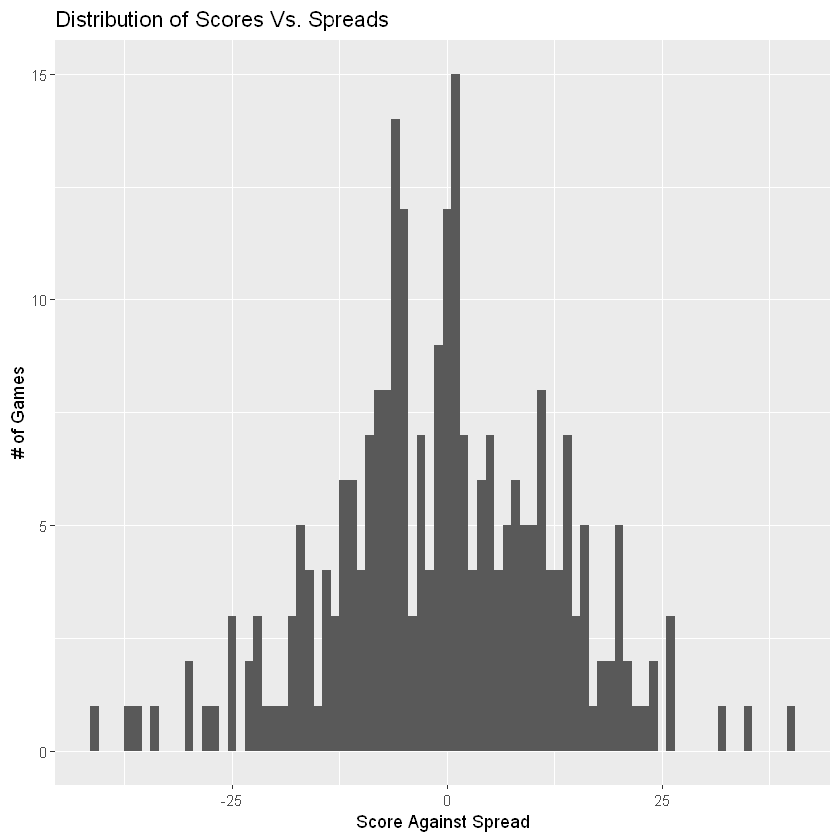

In [88]:
summary_stats = score_against_spread %>% summarize(mean = mean(score_against_spread), se = sd(score_against_spread)/sqrt(n()))
print(summary_stats)
ggplot(score_against_spread) + geom_histogram(aes(score_against_spread), binwidth = 1) + 
labs(x = "Score Against Spread", y = "# of Games", title = "Distribution of Scores Vs. Spreads")

We see from the graph that the distribution appears normal and centered at 0. We also see that are mean is within the standard error of 0. Therefore, we can not conclude that the favored team plays better than projected on average.

We have completed our analysis of S.A.S by itself. Now, we are looking at draft order. We use the _players_ dataset to make a table with a row for each player and the round they were picked in, the number of the overall pick, and a row index. We got rid of missing values, which corresponded to undrafted players, by saying they were picked in round 8 (there are only 7 rounds) and saying they were picked with a number corresponding to the last overall pick plus one. This way, they would have numeric values, and shown to be chosen after those who were drafted.

In [13]:
player_by_pick = players %>% select(team, round, pick, pickround, picktotal) %>%
filter((picktotal > (round-1)*32 & picktotal <= round * 32) | is.na(picktotal)) %>%
mutate(picktotal = ifelse(is.na(picktotal) | round == 0, max(round, na.rm=T)*max(pickround, na.rm=T) + 1, picktotal),
      round = ifelse(is.na(round) | round == 0, max(round, na.rm=T) + 1, round)) %>%
select(team, round, picktotal) %>%
mutate(k = row_number())
head(player_by_pick)

team,round,picktotal,k
<chr>,<dbl>,<dbl>,<int>
CIN,1,4,1
KC,1,30,2
NE,8,239,3
GB,1,24,4
JAC,4,101,5
MIN,1,7,6


Now, we create the table _pick_vs_spread_allv_ (all variables) by joining the table above with our _sas_ table from earlier. From now on, we will use _sas_ not _score_against_spread_ because we want to analyze every team, not just favored teams. The joined table has a column for each player, and the team statistics represent the performance of that player's team. We keep the all variables table for the variable _home_margin_ which will be used to observe effects of draft order on team performance. We only need this stat for one section, so we make another table _pick_vs_spread_ which omits this variable.

In [14]:
pick_vs_spread_allv = left_join(player_by_pick, sas, by = c("team" = "team_of_interest")) %>%
arrange(picktotal) %>% print
pick_vs_spread = select(pick_vs_spread_allv, round, picktotal, score_against_spread) %>% print



# A tibble: 7,398 x 14
   team  round picktotal     k home_abb away_abb team_favorite_id
   <chr> <dbl>     <dbl> <int> <chr>    <chr>    <chr>           
 1 CIN       1         1     9 CIN      PIT      CIN             
 2 CIN       1         1     9 CLE      CIN      CIN             
 3 CIN       1         1     9 BUF      CIN      CIN             
 4 CIN       1         1     9 CIN      NYJ      CIN             
 5 CIN       1         1     9 MIA      CIN      CIN             
 6 CIN       1         1     9 CIN      CLE      CIN             
 7 CIN       1         1     9 SD       CIN      CIN             
 8 CIN       1         1     9 CIN      IND      CIN             
 9 CIN       1         1     9 PIT      CIN      CIN             
10 CIN       1         1     9 CIN      MIN      CIN             
# ... with 7,388 more rows, and 7 more variables: spread_favorite <dbl>,
#   score_home <dbl>, score_away <dbl>, home_margin <dbl>, home_favored <lgl>,
#   favored_margin <dbl>, score_a

Now, we try to explicitly analyze the relationship between draft order and team performance. We create _team_margin_ which is negative if the team in question loses and positive if they win, and shows the margin of loss/victory. Since graphing a point for every player would clutter the graph, we grouped the data by both the overall pick number and the round they were picked in. We calculated the mean and standard deviation of _team_margin_ for each pick number and round, and created four plots. We made two separate graphs for by pick analysis and by round analysis.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



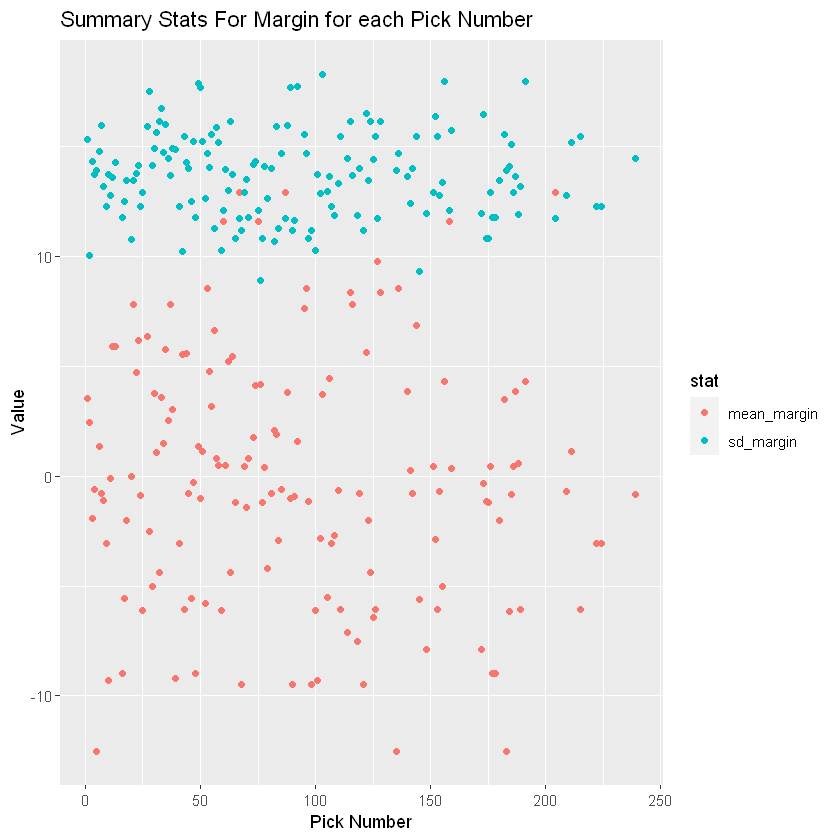

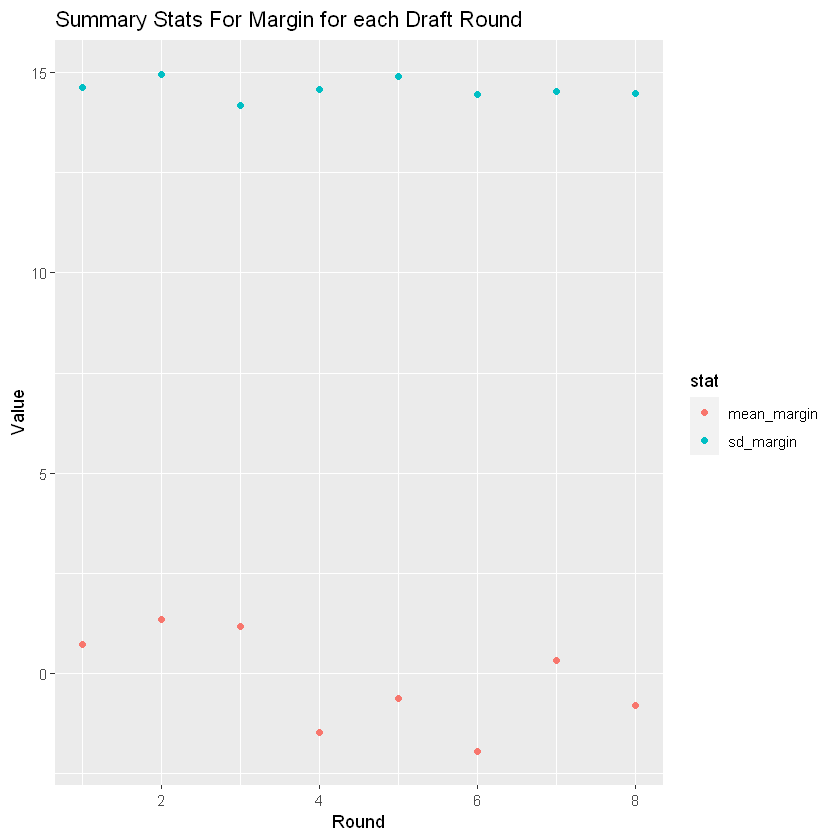

In [39]:
pick_variation = pick_vs_spread_allv %>% mutate(team_margin = ifelse(team == home_abb, home_margin, -1*home_margin)) %>%
select(picktotal,team, home_abb, score_home, score_away, home_margin, team_margin, round)
summary_pick = pick_variation %>% group_by(picktotal) %>% 
summarize(mean_margin = mean(team_margin),sd_margin = sd(team_margin)) %>%
gather("stat", "value", c("mean_margin", "sd_margin"))
summary_round = pick_variation %>% group_by(round) %>%
summarize(mean_margin = mean(team_margin), sd_margin = sd(team_margin)) %>%
gather("stat", "value", c("mean_margin", "sd_margin"))
ggplot(summary_pick) + geom_point(aes(x=picktotal, y = value, color = stat)) + 
labs(x = "Pick Number", y = "Value", title = "Summary Stats For Margin for each Pick Number")
ggplot(summary_round) + geom_point(aes(x=round, y = value, color = stat)) +
labs(x = "Round", y = "Value", title = "Summary Stats For Margin for each Draft Round")

For both the pick number graph, the means and standard deviations don't appear to trend upwards or downwards. Therefore, it would be tough to conclude if a player's overall pick number or even draft round affects how well his team plays or how wide the range of his team's potential performance is. 

We found no clear correlations when oberving how draft order affects a player's team's performance against their opponent. Now, here is where things get interesting. What if those making the Vegas odds are biased about players based on when they were drafted? We are going to analyze how our three main stats -- overall pick, round, and S.A.S -- are correlated.

We already have a table _pick_vs_spread_ which relates the three stats with one row per player. We can now graph S.A.S vs both pick number and round.

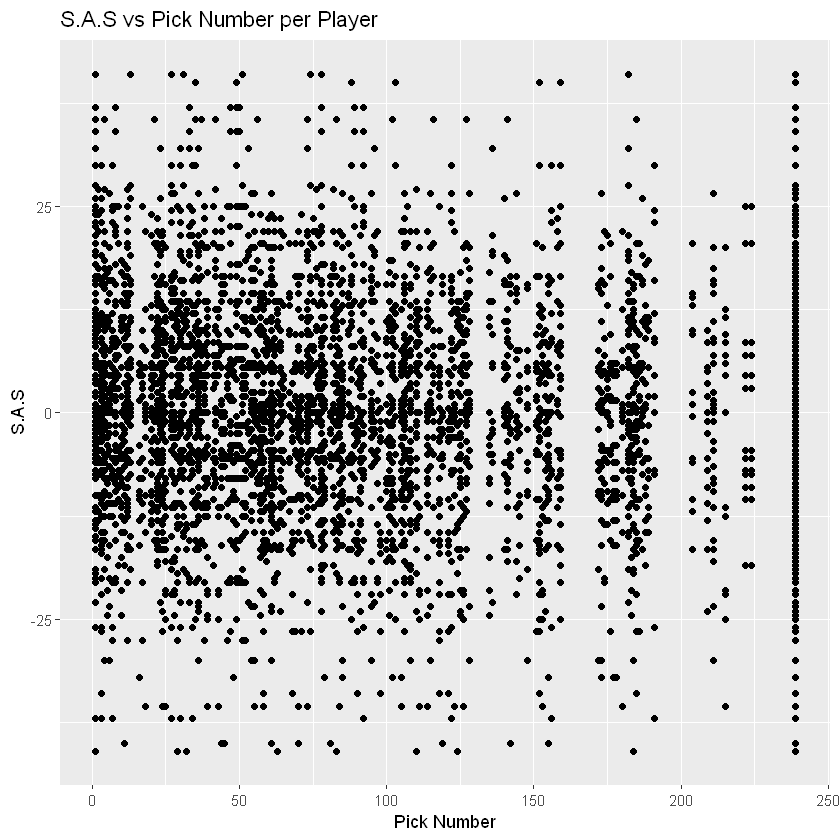

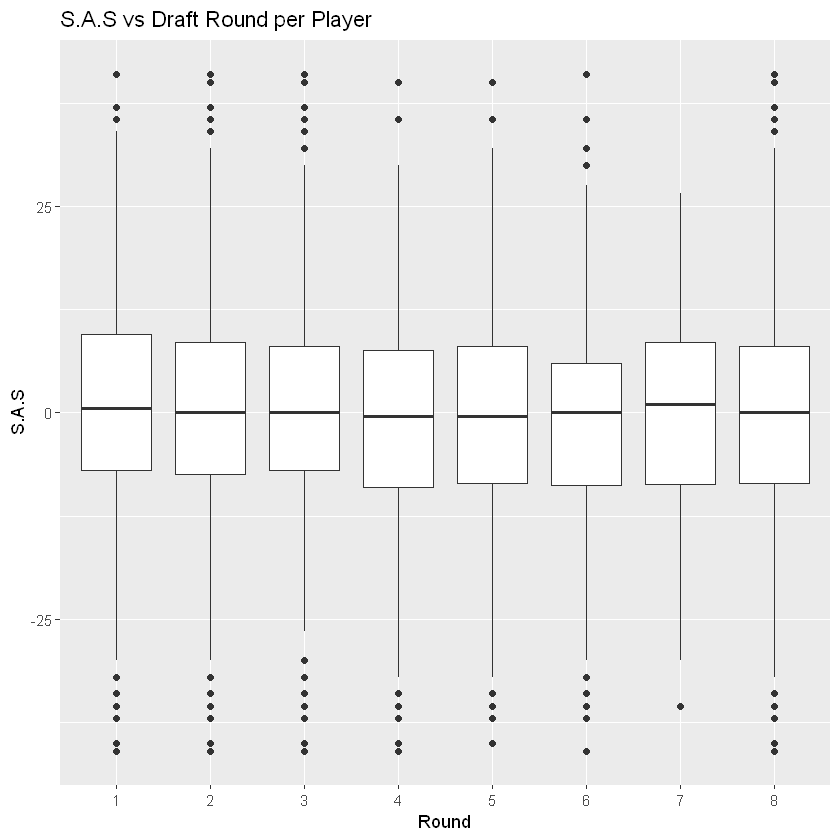

In [38]:
ggplot(pick_vs_spread) + geom_point(aes(x=picktotal, y=score_against_spread)) +
labs(x = "Pick Number", y = "S.A.S", title = "S.A.S vs Pick Number per Player")
ggplot(pick_vs_spread) + geom_boxplot(aes(as.character(round), score_against_spread)) +
labs(x = "Round", y = "S.A.S", title = "S.A.S vs Draft Round per Player") 

Here, there are so many data points that the graphs are cluttered. We can't conclude much about the overall pick plot due to a massive number of points. We can observe changes of median value in the boxplot, but with so much data it is hard to see a clear trend. Now, like earlier, we make plots of summary statistics. We make one graph for overall pick and one for round, with one data point per pick number and round respectively.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



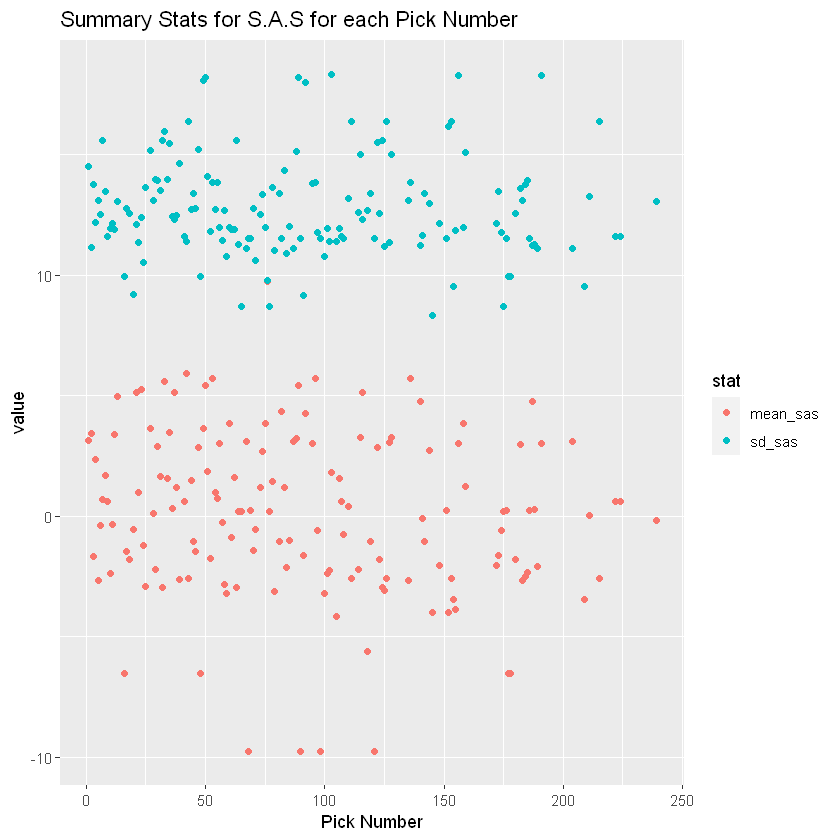

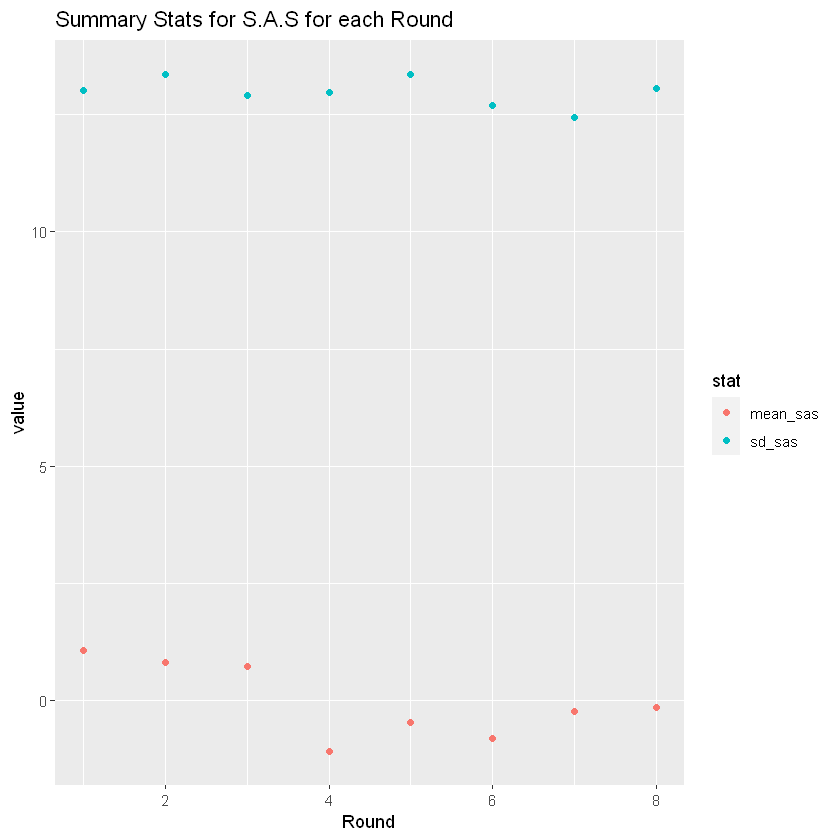

In [51]:
summary_pick_vs_spread = pick_vs_spread %>% group_by(picktotal) %>%
summarize(mean_sas = mean(score_against_spread), sd_sas = sd(score_against_spread)) %>%
gather("stat", "value", c("mean_sas", "sd_sas"))
ggplot(summary_pick_vs_spread) + geom_point(aes(x=picktotal, y=value, color = stat)) + 
labs(x = "Pick Number", y = "value", title = "Summary Stats for S.A.S for each Pick Number")
summary_round_vs_spread = pick_vs_spread %>% group_by(round) %>%
summarize(mean_sas = mean(score_against_spread), sd_sas = sd(score_against_spread)) %>%
gather("stat", "value", c("mean_sas", "sd_sas"))
ggplot(summary_round_vs_spread) + geom_point(aes(x=round, y=value, color = stat)) + 
labs(x = "Round", y = "value", title = "Summary Stats for S.A.S for each Round")

Again, for the pick number graph, the means and standard deviations don't appear to trend up or down. Therefore, we can not conclude that a player's overall pick number is correlated to their teams performance against Vegas odds or the range of performance against the spread. With the round graph, we don't see a clear correlation with the standard deviations, but the means appear to trend downward. However, the trend appears more like an exponential decay than linear. Therefore, we tried an exponential regression model with the form $y = A + Be^{kx}$. The exponential term _k_ can be varied, so we changed it until it appeared to best fit our data, which was at $k = -1/2$. We made the model and we show below ou summary stats and plot of both the model and our data.

`summarise()` ungrouping output (override with `.groups` argument)




Call:
lm(formula = score_against_spread ~ expterm, data = pick_vs_spread)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.167  -8.187   0.018   8.313  41.313 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.3587     0.2003  -1.791 0.073357 .  
expterm       2.5161     0.7235   3.478 0.000509 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13.06 on 7396 degrees of freedom
Multiple R-squared:  0.001633,	Adjusted R-squared:  0.001498 
F-statistic: 12.09 on 1 and 7396 DF,  p-value: 0.0005088


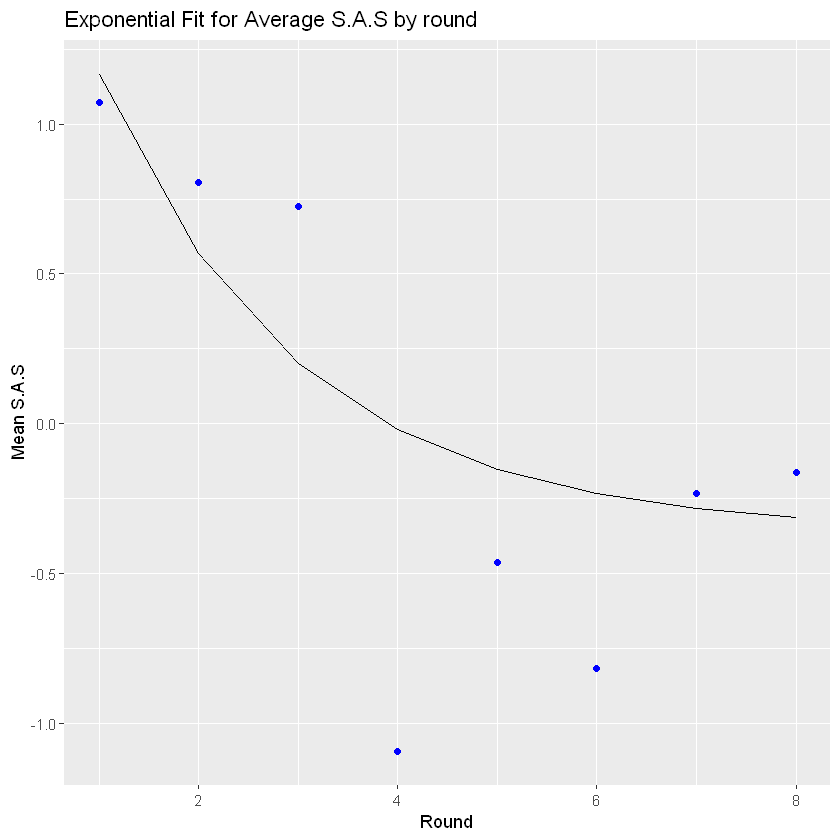

In [86]:
summary_round_vs_spread = pick_vs_spread %>% group_by(round) %>%
summarize(mean_sas = mean(score_against_spread), sd_sas = sd(score_against_spread))
k = -1/2
pick_vs_spread = pick_vs_spread %>% mutate(expterm = exp(k*round))
expreg = lm(score_against_spread ~ expterm, data = pick_vs_spread)
summary(expreg)
pick_vs_spread = pick_vs_spread %>% add_predictions(expreg)
ggplot() +  geom_point(data = summary_round_vs_spread, aes(x=round, y=mean_sas), color = "blue") + 
geom_line(data = pick_vs_spread, aes(round, pred)) +
labs(x = "Round", y = "Mean S.A.S", title = "Exponential Fit for Average S.A.S by round")

The summary stats for this exponential fit show the trend $MeanSASPerRound = -0.3587 + 2.5161e^{-round/2}$. The y intercept is only useful for calculating the predicted mean S.A.S when given a round, because there is no 0th round. The fit shows a sharp decreae in performance against spread in the early rounds, followed by not much change at all for later rounds. The $r^2$ coefficient is only 0.01, so we can not conclude that there is a trend of performance against spread and round number, but if they are related, it shows that those in Vegas who make the odds slightly underestimate team performance for players that have been drafted in earlier rounds, and they estimate accurately team performance for players drafted in later rounds, since the curve plateaus around 0.

Since the only correlation that might exist so far is related to rounds, we dove into individual rounds and spread statistics within these rounds. First, we were perplexed about why undrafted players actually had a higher mean S.A.S then their late-round companions. So, we investigated how teams with more or less undrafted players performed against the spread. We created two helper table, each with a row per team. One had the number of undrafted players and the other had the mean S.A.S for the team. We joined the tables and plotted S.A.S vs number of undrafted players per team. Then, on the same graph, we plotted the mean S.A.S for each team total of undrafted players. From these two plots, we saw a negative correlation that appeared linear. So, we did a linear fit of S.A.S vs number of undrafted players and plotted our fit on the graph.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)




Call:
lm(formula = score_against_spread ~ undrafted, data = undrafted_vs_sas)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.7577  -2.3456  -0.0586   2.8292   8.0898 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   3.6178     1.8462   1.960   0.0594 .
undrafted    -0.6525     0.3470  -1.881   0.0698 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.893 on 30 degrees of freedom
Multiple R-squared:  0.1055,	Adjusted R-squared:  0.07565 
F-statistic: 3.537 on 1 and 30 DF,  p-value: 0.06975


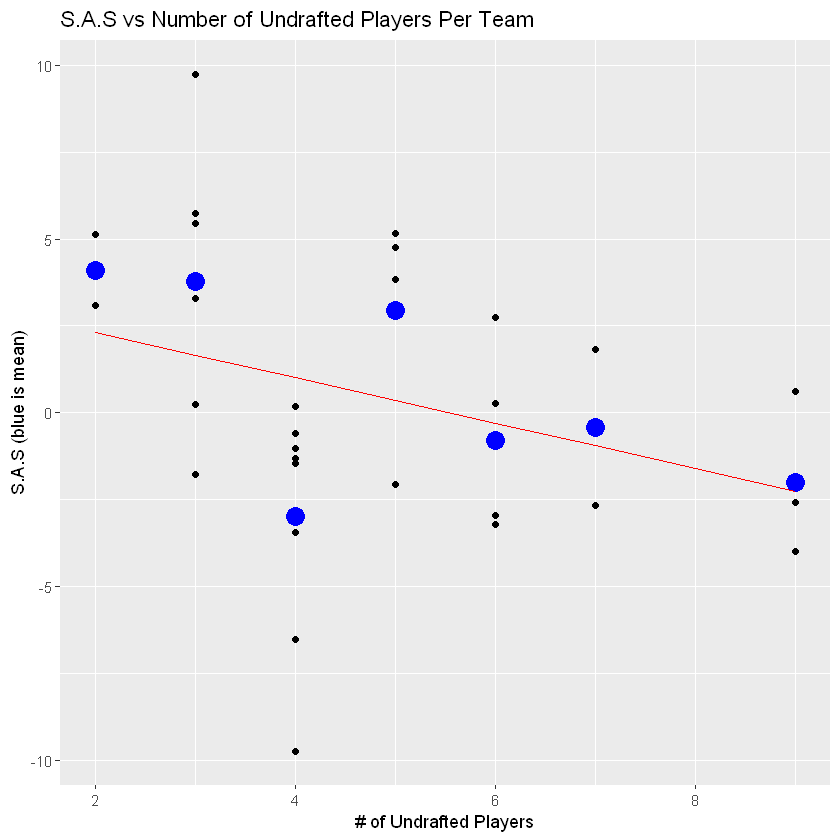

In [87]:
dfa = players %>% mutate(undrafted = is.na(round)) %>%
group_by(team) %>% summarize(undrafted = sum(undrafted))
dfb = sas %>% group_by(team_of_interest) %>% summarize(score_against_spread = mean(score_against_spread))
undrafted_vs_sas = left_join(dfa, dfb, by = c("team" = "team_of_interest"))
mean_ud = undrafted_vs_sas %>% group_by(undrafted) %>% summarize(score_against_spread = mean(score_against_spread))
lm = lm(score_against_spread ~ undrafted, data = undrafted_vs_sas)
summary(lm)
undrafted_vs_sas = undrafted_vs_sas %>% add_predictions(lm) %>% add_residuals(lm)
ggplot() + geom_point(data = undrafted_vs_sas, aes(x=undrafted, y = score_against_spread)) +
geom_point(data = mean_ud, aes(x=undrafted, y = score_against_spread), color = "blue", size = 5) +
geom_line(data = undrafted_vs_sas, aes(x=undrafted, y = pred), color = "red") + 
labs(x = "# of Undrafted Players", y = "S.A.S (blue is mean)", title = "S.A.S vs Number of Undrafted Players Per Team")

You can see, as I described earlier, that the data had a negative linear trend. This is especially clear with the large blue dots representing mean S.A.S for each number of undrafted players. Our linear fit produced the equation $SAS = 3.6178 - 0.6525NumUD$. The y intercept represents a team with no undrafted players' average S.A.S. It is higher than 0, but not as high as the standard error, so the value is not significant. There is a weak linear trend with a small slope and a $R^2$ of 0.1, which is higher than our last $R^2$ but still not high. Since the slope is so low compared to our standard error, we can not conclude that teams with more undrafted players have a lower S.A.S. This may show that there are many confounding variables, or that those who make Vegas odds have little to no bias with undrafted players, and that you can't count out a team just because they have a lot of them.

Next, we investigated a similar concept but with first round draft picks instead of undrafted players. We used the exact same process with helper tables and mean S.A.S for each number of first round picks. We used the same graphing format, but this time we didn't feel the need to even try a linear fit.

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



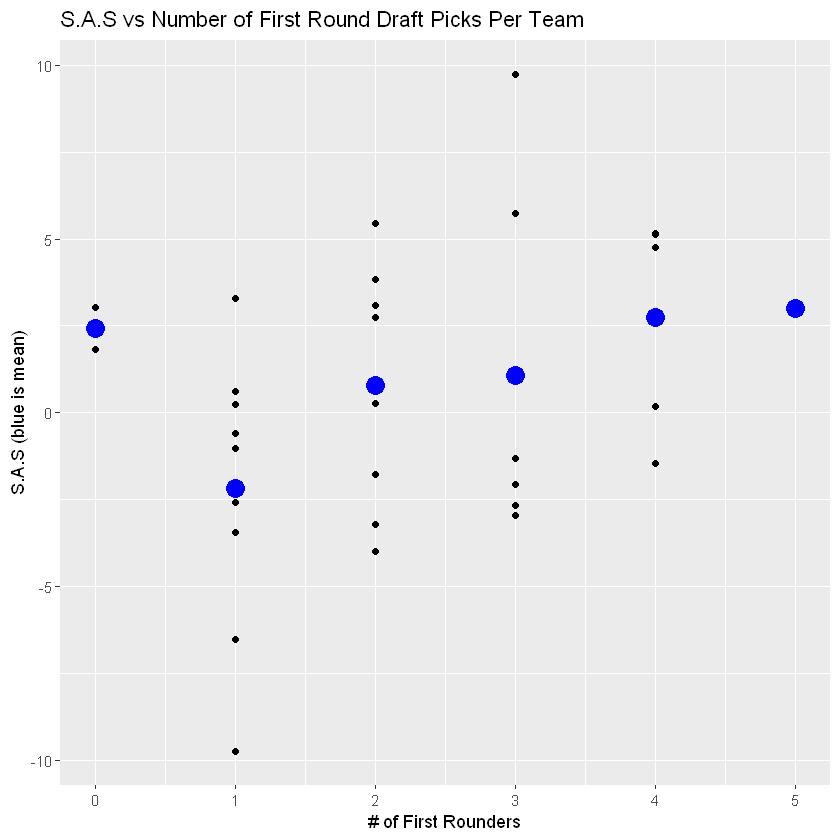

In [47]:
dfc = players %>% mutate(firstround = (round == 1)) %>%
group_by(team) %>% summarize(firstround = sum(firstround, na.rm = T))
dfd = sas %>% group_by(team_of_interest) %>% summarize(score_against_spread = mean(score_against_spread))
firstround_vs_sas = left_join(dfc, dfd, by = c("team" = "team_of_interest"))
mean_fr = firstround_vs_sas %>% group_by(firstround) %>% summarize(score_against_spread = mean(score_against_spread))
ggplot() + geom_point(data = firstround_vs_sas, aes(x=firstround, y = score_against_spread)) +
geom_point(data = mean_fr, aes(x=firstround, y = score_against_spread), color = "blue", size = 5) +
labs(x = "# of First Rounders", y = "S.A.S (blue is mean)", title = "S.A.S vs Number of First Round Draft Picks Per Team")

You can see that there is no strong rise or decline with the individual data points or the means highlighted in blue. We will not be able to conclude that more first round picks helps teams against the spread. This either shows the power of betting odds or the lack of importance of draft order. With seven rounds in a draft and players not always doing what they were projected to do while in college, first rounders may just help a team less than people think.

In this question, did we find any strong correlations? No. Was it all for nothing? Or course not. Strong correlations were expected for some of these sub-questions, and surprisingly we didn't find any. We were very surprised that players drafted in earlier rounds didn't perform better against the spead that those in later rounds, for example. Maybe we ran into a lot of confounding variables, or maybe we were able to see how smart you have to be to make betting odds. Maybe the oddsmakers use similar techniques to us? Maybe they don't. We don't know, and there is far more research to be done on this topic and related ones. If this question taught us anything, its that answering questions like this open up boundless further research opportunities. To answer this question simply, we did not find that draft order affect how well players and teams perform against the spread.

# Question 2 - Teddy
## How does weather affect how the average offense picks plays for each game?

With the availability of basic weather figures for every regular season game in 2013 as well as play-by-play data for the same games, it raises interesting questions surrounding whether or not that weather has an effect on teams' offenses. **How does weather in general and how do specific "weather states" change how offenses pick plays for the entirety of the game?** To start this analysis, we will need to join the two tables together. We are also only interested in the variables that will help us understand the relationship between weather and offensive play choices such as when the game was played, what types of plays were run, as well as the temperature, wind speed, and wind chill experienced during each game. We also know that we are only interested in outdoor games and that indoor games are input temperature values of 0 so we must filter these out for our further analysis. In our analysis, we use the package gridextra which allows us to plot multiple graphs aligned with each other.

In [96]:
play_weather_join <- full_join(x = plays, y = games, by = c('game_id'))
play_weather_condensed <- play_weather_join %>% 
  select(game_id, game_date, home_team.x, away_team.x, play_type, week, 
         temperature, wind_chill, wind_mph)
play_weather_outdoor_only<- play_weather_condensed %>% filter(temperature != 0) %>% print

# A tibble: 39,895 x 9
   game_id game_date  home_team.x away_team.x play_type  week temperature
     <dbl> <date>     <chr>       <chr>       <chr>     <dbl>       <dbl>
 1  2.01e9 2013-09-05 DEN         BAL         kickoff       1          83
 2  2.01e9 2013-09-05 DEN         BAL         pass          1          83
 3  2.01e9 2013-09-05 DEN         BAL         run           1          83
 4  2.01e9 2013-09-05 DEN         BAL         pass          1          83
 5  2.01e9 2013-09-05 DEN         BAL         punt          1          83
 6  2.01e9 2013-09-05 DEN         BAL         pass          1          83
 7  2.01e9 2013-09-05 DEN         BAL         run           1          83
 8  2.01e9 2013-09-05 DEN         BAL         pass          1          83
 9  2.01e9 2013-09-05 DEN         BAL         pass          1          83
10  2.01e9 2013-09-05 DEN         BAL         run           1          83
# ... with 39,885 more rows, and 2 more variables: wind_chill <dbl>,
#   wind_mph <dbl>


We want to first explore the data we have so we have a solid understanding of how it is distributed in order to make a dive deeper into the question at hand. We can see that *temperature* varies in a relatively large range with mean centered at 60.35 F. Wind speed averages at 9.283 mph across all outdoor games with rather extreme outliers to the high end of spectrum. Wind chill can be observed as pretty stable with a vast majority of games experiencing no wind chill at all. Because of this we choose to move forward with exploring temperature and wind speed as everygame has much more variable and continous values for both. We will also use the quartile values to define three weather states to understand how offensive play choices adapt to each state. 

  temperature       wind_mph        wind_chill  
 Min.   :18.00   Min.   : 1.000   Min.   : 0.0  
 1st Qu.:56.00   1st Qu.: 6.000   1st Qu.: 0.0  
 Median :64.00   Median : 8.000   Median : 0.0  
 Mean   :60.35   Mean   : 9.283   Mean   : 2.6  
 3rd Qu.:72.00   3rd Qu.:12.000   3rd Qu.: 0.0  
 Max.   :89.00   Max.   :31.000   Max.   :30.0  


Warning message:
“Removed 2853 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 10315 rows containing non-finite values (stat_boxplot).”


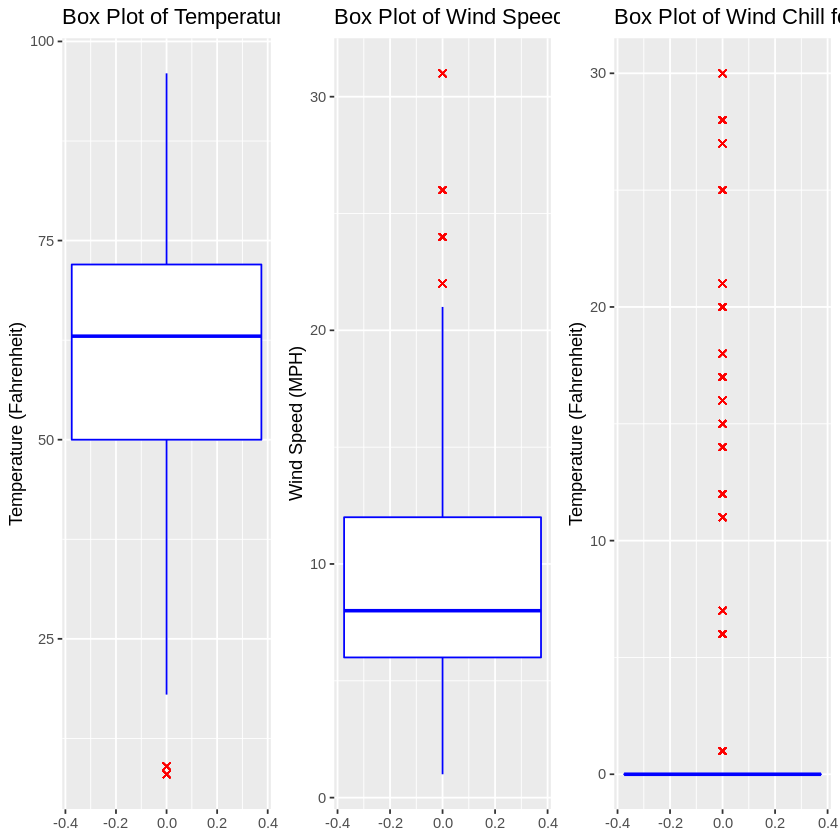

In [60]:
play_weather_outdoor_only %>% filter(across(c(temperature,wind_mph,wind_chill,humidity), ~ !is.na(.x))) %>% 
  select(temperature, wind_mph, wind_chill) %>% summary() %>% print 
temp_box <- play_weather_outdoor_only %>% 
  ggplot() +
  geom_boxplot(mapping = aes(y = temperature), fill = 'white', colour = 'blue', outlier.colour = 'red', outlier.shape = 4) +
  labs(title = 'Box Plot of Temperatures for Outdoor Games', y = 'Temperature (Fahrenheit)')
wind_box <- play_weather_outdoor_only %>% 
  ggplot() +
  geom_boxplot(mapping = aes(y = wind_mph), fill = 'white', colour = 'blue', outlier.colour = 'red', outlier.shape = 4) +
  labs(title = 'Box Plot of Wind Speed for Outdoor Games', y = 'Wind Speed (MPH)')
chill_box <- play_weather_outdoor_only %>% 
  ggplot() +
  geom_boxplot(mapping = aes(y = wind_chill), fill = 'white', colour = 'blue', outlier.colour = 'red', outlier.shape = 4) +
  labs(title = 'Box Plot of Wind Chill for Outdoor Games', y = 'Temperature (Fahrenheit)') 
grid.arrange(temp_box, wind_box, chill_box, nrow=1)

The summary statistics as well as the box-plots provided us a great idea of the distribution of values for both wind and temperature; however, before beginning to define weather states, it will be helpful to explore how the average wind speed and temperature changes over the length of the season. At the same time we can begin to investigate how offensive play choice changes over the season. The reason we choose to explore this is the fact that since we know the NFL season starts in Septemeber and ends in early January, winter weather also progresses to lower temperatures and, in many cases, more erratic wind. The hypothesis is then that offensive most likely adapt their offensives to the changing weather over the course of the season. We can begin to test and visualize this hypothesis by creating scatter plots with localized regression lines to compare the trends. 

We can see that as each week passes mean temperatures trend much lower than where they began, mean wind speeds pick up into the middle of the season before falling off again, and the percentage of offensive plays per game defined as passing plays trends down throughout the season, suggesting that there is a correlation between our predictors: wind speed & temperature, and our response: mean passing play percentage. 

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'week' (override with `.groups` argument)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



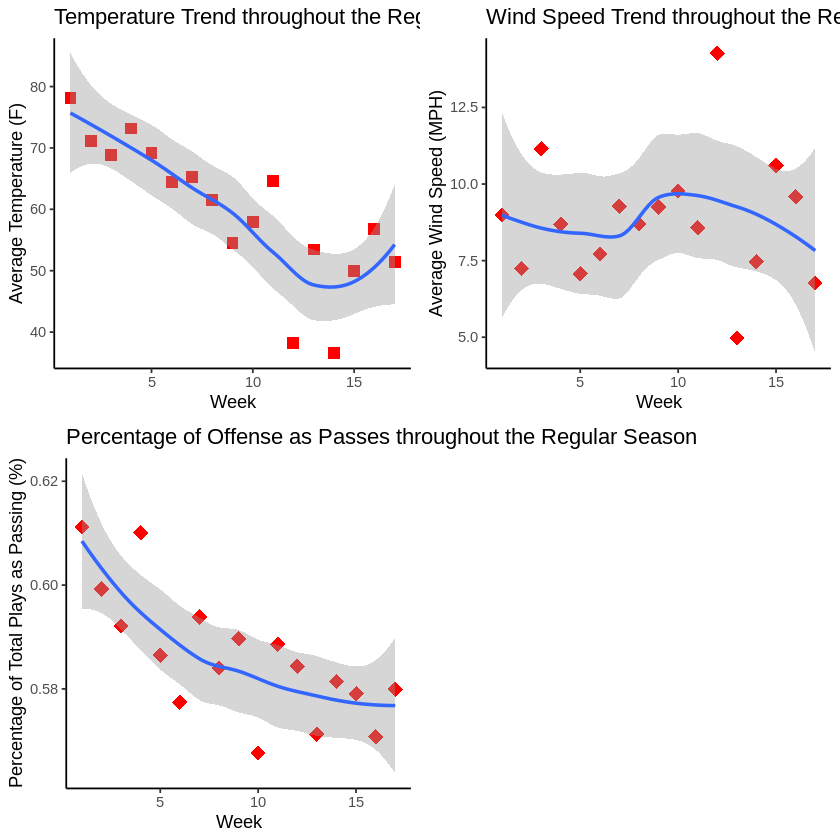

In [59]:
temp_scatter <- play_weather_outdoor_only %>% group_by(week) %>% filter(!is.na(temperature)) %>% 
  summarise(Avg_Temp = mean(temperature)) %>% 
  ggplot() +
  geom_point(mapping = aes(x = week, y = Avg_Temp),shape = 15, size = 3, color = 'red') +
  geom_smooth(mapping = aes(x = week, y = Avg_Temp), method = "loess", se = T, level = 0.90) +
  labs(title = 'Temperature Trend throughout the Regular Season', x = 'Week', y = 'Average Temperature (F)') +
  theme_classic()
wind_scatter <- play_weather_outdoor_only %>% group_by(week) %>% filter(!is.na(wind_mph)) %>% 
  summarise(Avg_Wind = mean(wind_mph)) %>% 
  ggplot() +
  geom_point(mapping = aes(x = week, y = Avg_Wind),shape = 18, size = 4, color = 'red') +
  geom_smooth(mapping = aes(x = week, y = Avg_Wind), method = "loess", se = T, level = 0.90) +
  labs(title = 'Wind Speed Trend throughout the Regular Season', x = 'Week', y = 'Average Wind Speed (MPH)') +
  theme_classic()
passing_scatter <- play_weather_outdoor_only %>% filter(play_type == 'pass' | play_type == 'run') %>%
  group_by(week,play_type) %>% summarise(count = n()) %>% spread(key = play_type, value = count) %>% 
  mutate(average_passpct = pass / sum(pass,run)) %>% select(week, average_passpct) %>%
  ggplot() +
  geom_point(mapping = aes(x = week, y = average_passpct),shape = 18, size = 4, color = 'red') +
  geom_smooth(mapping = aes(x = week, y = average_passpct), method = "loess", se = T, level = 0.90) +
  labs(title = 'Percentage of Offense as Passes throughout the Regular Season', x = 'Week', y = 'Percentage of Total Plays as Passing (%)') +
  theme_classic()
grid.arrange(temp_scatter, wind_scatter, passing_scatter, nrow = 2)

Now that we were able to see a correlation from our scatter and smooth plots, we can define and summarise three weather states to explore their effect on average passing play percentage *(Pass / (Pass+Run))*. 

We define the three weather states as such:


*   Inclement weather : Wind > 3rd quartile *(12mph)* & Temperature < 1st quartile *(56 F)*
*   Mild weather : 1st quartile < Wind < 3rd quartile *(6mph - 12mph )* & 1st quartile < Temperature < 3rd quartile *(56 F - 72 F)*
*  Steady Warm weather : Wind < 1st quartile *(6mph)* & Temperature > 3rd quartile *(72 F)*

After defining these weather states and grouping by such, we were able to explore how play type was associated with each state. Specifically we explored the value of percentage of offensive plays run as passes (defined above) for each state. The table below displays these values and we can see that although an Inclement weather state had the lowest percentage, as would be hypothesized, the difference is not as large as we would have expected. 


In [58]:
weekly_plays <- play_weather_outdoor_only %>% filter(!is.na(temperature) & !is.na(wind_mph)) %>% 
  mutate(inclement_weather = ifelse(temperature < 56 & wind_mph > 12, "inclement", F), 
         mild_weather = ifelse(56 < temperature & temperature < 72 & 6 < wind_mph & wind_mph < 12 , "mild", F), 
         steady_warm_weather = ifelse(72 < temperature & wind_mph < 6 , "steady warm", F)) %>% 
  mutate(weather = ifelse(inclement_weather == 'inclement', yes = "inclement", no = (ifelse(mild_weather == "mild", "mild", "steady_warm")))) %>%
  select(-c(inclement_weather, mild_weather, steady_warm_weather)) %>% filter(play_type == 'pass' | play_type == 'run') %>% 
  group_by(weather,play_type) %>% summarise(count = n()) %>% unite(Weather_Play, c(weather, play_type)) %>% 
  spread(key = Weather_Play, value = count) %>% 
  summarise(Inclement = (inclement_pass / (inclement_pass + inclement_run)), 
            Mild = (mild_pass / (mild_pass + mild_run)), 
            Steady = (steady_warm_pass / (steady_warm_pass + steady_warm_run))) %>% 
  pivot_longer(cols = c(Inclement, Mild, Steady), names_to = "Weather", values_to = "Pass_Percentage" ) %>% print()

`summarise()` regrouping output by 'weather' (override with `.groups` argument)



# A tibble: 3 x 2
  Weather   Pass_Percentage
  <chr>               <dbl>
1 Inclement           0.557
2 Mild                0.588
3 Steady              0.587


These values are visualized below with the inclusion of the average pass percent for **all** outdoor games included as a horizontal intercept line. 

`summarise()` ungrouping output (override with `.groups` argument)



Average percent of offensive plays as passes for all outdoor games is 0.5866579 %

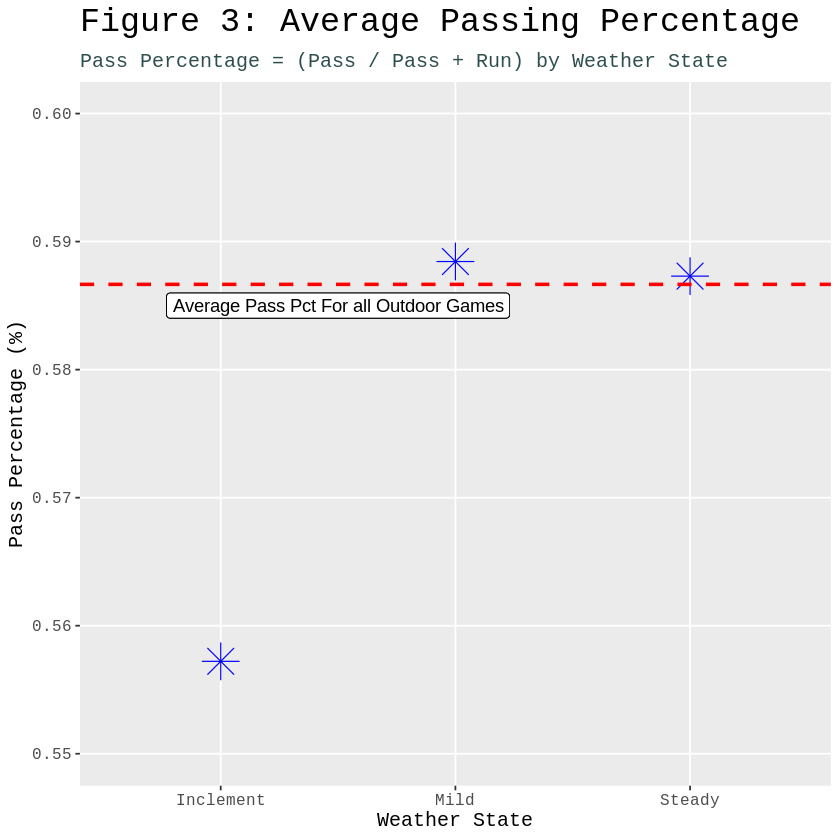

In [57]:
average_passpct_intercept <- play_weather_outdoor_only %>% filter(play_type == 'pass' | play_type == 'run') %>% 
  group_by(play_type) %>% summarise(count = n()) %>% spread(key = play_type, value = count) %>% 
  mutate(average_passpct = pass / sum(pass,run)) %>% select(average_passpct) %>% pull
cat("Average percent of offensive plays as passes for all outdoor games is", average_passpct_intercept,"%")
weekly_plays %>% 
  ggplot + 
  geom_point(mapping = aes(x = Weather, y = Pass_Percentage), shape = 8, size = 7, color = 'blue') +
  geom_hline(yintercept = average_passpct_intercept, linetype = 'dashed', color = 'red', size = 1) +
  geom_label(x = 1.5, y = 0.585, label = "Average Pass Pct For all Outdoor Games") + 
  ylim(0.55, 0.60) +
  labs(y = "Pass Percentage (%)", x = "Weather State") +
  ggtitle("Figure 3: Average Passing Percentage",
          subtitle = "Pass Percentage = (Pass / Pass + Run) by Weather State") +
  theme(panel.grid.minor = element_blank(),
        text = element_text(family = "Georgia", size = 12),
        plot.title = element_text(size = 20, margin = margin(b = 10)),
        plot.subtitle = element_text(size = 12, color = "darkslategrey"))

Finally, to find the true effect of wind speed and temperature on passing percentage, we can run a linear regression using the lm() function using with mean passing percent as our response to the predictors of temp and wind. After running the regression we find that although neither predictor is statistically significant using a p-value of 0.05 given temp = 0.106 and wind = 0.084, they are both rather low and coincide with the visual and stastical trends we witnessed above. We know that the NFL is in a pass-heavy era and is backed up by the intercept estimate of 0.574. This means that neglecting all predictors and set to zero, teams on average will run an offense that performs ~57% of plays as passing plays. The temp coefficient estimate suggest that as temperature increases, so does passing percentage, while the wind coefficient estimate suggests that every increase of one in wind speed decreases mean passing percentage for the game by about 1/10th of a percent.

In [56]:
weather_lm_data <- play_weather_outdoor_only %>% select(game_id, play_type, temperature, wind_mph, wind_chill) %>%
  filter(play_type == "pass" | play_type == "run") %>% group_by(game_id, play_type) %>% 
  summarise(count = n(), temp = temperature, wind = wind_mph, chill = wind_chill) %>% unique() %>% 
  spread(key = play_type, value = count) %>% mutate(average_passpct = pass / sum(pass,run)) %>% ungroup() %>%
  select(temp, wind, chill, average_passpct) %>% filter(!is.na(temp) & !is.na(wind))
weather_pass_model <- lm(data = weather_lm_data, formula = average_passpct ~ temp + wind)
summary(weather_pass_model)

`summarise()` regrouping output by 'game_id', 'play_type' (override with `.groups` argument)




Call:
lm(formula = average_passpct ~ temp + wind, data = weather_lm_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.180312 -0.039601 -0.000788  0.039565  0.172193 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.5744597  0.0175349  32.761   <2e-16 ***
temp         0.0003893  0.0002396   1.625    0.106    
wind        -0.0015515  0.0008935  -1.736    0.084 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06096 on 206 degrees of freedom
Multiple R-squared:  0.02999,	Adjusted R-squared:  0.02057 
F-statistic: 3.184 on 2 and 206 DF,  p-value: 0.04346


By exploring our the relationship between weather and play data by visualizing, summarizing, mutating, and modeling it, our question of **how temperature and various weather states affects offensive play choices** was answered by learning that warmer games lead to more passing while windier games lead to less passing for an offense. 

# Question 3 - Caleb
## Who is the best and worst starting quarterback in the NFL during the 2013 season?

To answer this question we are going to finding the highest and lowest performing quarterbacks on certain statistics that help to show whether or not a quarterback performs well. These statistics are Completion Percentage on Passes, Total Touchdowns Thrown, Total Interceptions Thrown, and Total Passing Yards Thrown. Through comparing the lists of starting quarterbacks based on these seasonal statistics we will be able to see who had the best season

In [97]:
quarterback_performance <- plays %>%
  filter(play_type=="pass") %>% 
#This filters the plays so that we are only looking pass plays from the plays data set
  mutate(Quarterback = paste(passer_player_name,posteam,sep=" ")) %>%
#Creating a new column of people who threw the ball during the season
  group_by(Quarterback, posteam) %>%
  summarise(Completed.Passes = sum(complete_pass),
            Incomplete.Passes = sum(incomplete_pass),
            Total.Passes = (Incomplete.Passes + Completed.Passes),
            Completion.Percentage = Completed.Passes/(Total.Passes),
            Interceptions = sum(interception),
            Touchdowns = sum(touchdown),
            Total.Passing.Yards = sum(yards_gained))%>%
#Above is creating total individual statistic catagories for the season from quarterbacks
#These statistics are the ones we feel as though show us who performed the best and the worst during the 2013 season 
filter(Total.Passes >= 250) %>% print
#All of the starting quarterbacks from the season threw over 250 passes this filter above helps us so we only look at them
#If we were not to do this we would get many quarterbacks who would throw off our data 

top_qb_completetion_percentage <- quarterback_performance %>%
select(Quarterback, Completion.Percentage) %>% 
arrange(desc(Completion.Percentage))
#This will order the quarterbacks from highest to lowest based on their season completetion percentage

bottom_qb_completetion_percentage <- quarterback_performance %>%
select(Quarterback, Completion.Percentage) %>%
arrange(Completion.Percentage)
#This will order the quarterbacks from lowest to highest based on their season completetion percentage 

most_qb_touchdowns <- quarterback_performance %>%
select(Quarterback, Touchdowns) %>% 
arrange(desc(Touchdowns))
#This will order the quarterbacks from highest to lowest based how many touchdowns they threw during the season

least_qb_touchdowns <- quarterback_performance %>%
select(Quarterback, Touchdowns) %>%
arrange(Touchdowns)
#This will order the quarterbacks from lowest to highest based how many touchdowns they threw during the season

least_qb_interceptions <- quarterback_performance %>%
select(Quarterback, Interceptions) %>% 
arrange(Interceptions)
#This will order the quarterbacks from lowest to highest based how many interceptions they threw during the season

most_qb_interceptions <- quarterback_performance %>%
select(Quarterback, Interceptions) %>%
arrange(desc(Interceptions))
#This will order the quarterbacks from highest to lowest based how many interceptions they threw during the season

top_qb_passing_yards <- quarterback_performance %>%
select(Quarterback, Total.Passing.Yards) %>% 
arrange(desc(Total.Passing.Yards))
#This will order the quarterbacks from highest to lowest based on their season's total passing yards thrown

bottom_qb_passing_yards <- quarterback_performance %>%
select(Quarterback, Total.Passing.Yards) %>%
arrange(Total.Passing.Yards)
#This will order the quarterbacks from lowest to highest based on their season's total passing yards thrown


`summarise()` regrouping output by 'Quarterback' (override with `.groups` argument)



# A tibble: 32 x 9
# Groups:   Quarterback [32]
   Quarterback posteam Completed.Passes Incomplete.Pass~ Total.Passes
   <chr>       <chr>              <dbl>            <dbl>        <dbl>
 1 A.Dalton C~ CIN                  363              200          563
 2 A.Luck IND  IND                  345              215          560
 3 A.Rodgers ~ GB                   193               90          283
 4 A.Smith KC  KC                   308              187          495
 5 B.Roethlis~ PIT                  369              181          550
 6 B.Weeden C~ CLE                  141              114          255
 7 C.Henne JAC JAC                  305              179          484
 8 C.Kaeperni~ SF                   243              164          407
 9 C.Newton C~ CAR                  292              165          457
10 C.Palmer A~ ARI                  362              184          546
# ... with 22 more rows, and 4 more variables: Completion.Percentage <dbl>,
#   Interceptions <dbl>, Touchdowns 

 A. Who were the top and bottom 5 starting quarterbacks for Completion Percentage during the 2013 season?

In [107]:
head(top_qb_completetion_percentage, 5)
#Top chart will show quarterbacks with the highest completion percentage
head(bottom_qb_completetion_percentage, 5)
#Bottom chart will show quarterbacks with the lowest completion percentage

Quarterback,Completion.Percentage
<chr>,<dbl>
P.Rivers SD,0.7110694
D.Brees NO,0.7025316
M.Ryan ATL,0.6968254
P.Manning DEN,0.6955178
A.Rodgers GB,0.6819788


Quarterback,Completion.Percentage
<chr>,<dbl>
B.Weeden CLE,0.5529412
G.Smith NYJ,0.5866983
J.Campbell CLE,0.5901639
C.Kaepernick SF,0.5970516
T.Pryor OAK,0.6078431


B. Who were the top and bottom 5 starting quarterbacks for total passing touchdowns? 

In [108]:
head(most_qb_touchdowns, 5)
#Top chart will show the quarterbacks who threw the most amount of touchdowns
head(least_qb_touchdowns, 5)
#Bottom chart will show the quarterbacks who threw the least amount of touchdowns

Quarterback,Touchdowns
<chr>,<int>
P.Manning DEN,57
D.Brees NO,40
A.Dalton CIN,35
M.Stafford DET,33
P.Rivers SD,33


Quarterback,Touchdowns
<chr>,<int>
T.Pryor OAK,8
B.Weeden CLE,10
E.Manuel BUF,11
J.Campbell CLE,13
C.Henne JAC,14


C. Who were the top and bottom 5 starting quarterbacks for total interceptions thrown?

In [109]:
head(least_qb_interceptions, 5)
#Top chart will show least amount of interceptions thrown
head(most_qb_interceptions, 5)
#Bottom chart will show most amount of interceptions thrown

Quarterback,Interceptions
<chr>,<int>
N.Foles PHI,2
S.Bradford STL,4
A.Rodgers GB,6
J.Campbell CLE,6
A.Smith KC,8


Quarterback,Interceptions
<chr>,<int>
E.Manning NYG,26
C.Palmer ARI,22
J.Flacco BAL,22
A.Dalton CIN,18
G.Smith NYJ,17


D. Who were the top and bottom 5 starting quarterbacks for pass completetion percention?

In [110]:
head(top_qb_passing_yards, 5)
#Top chart will show the quarterbacks who threw for the most amount of total passing yards 
head(bottom_qb_passing_yards, 5)
#Bottom chart will show the quarterback who threw for the least amount of total passing yards

Quarterback,Total.Passing.Yards
<chr>,<int>
P.Manning DEN,5357
D.Brees NO,4893
M.Stafford DET,4478
P.Rivers SD,4328
M.Ryan ATL,4217


Quarterback,Total.Passing.Yards
<chr>,<int>
S.Bradford STL,1590
T.Pryor OAK,1595
E.Manuel BUF,1817
M.Schaub HOU,2148
M.Glennon TB,2294


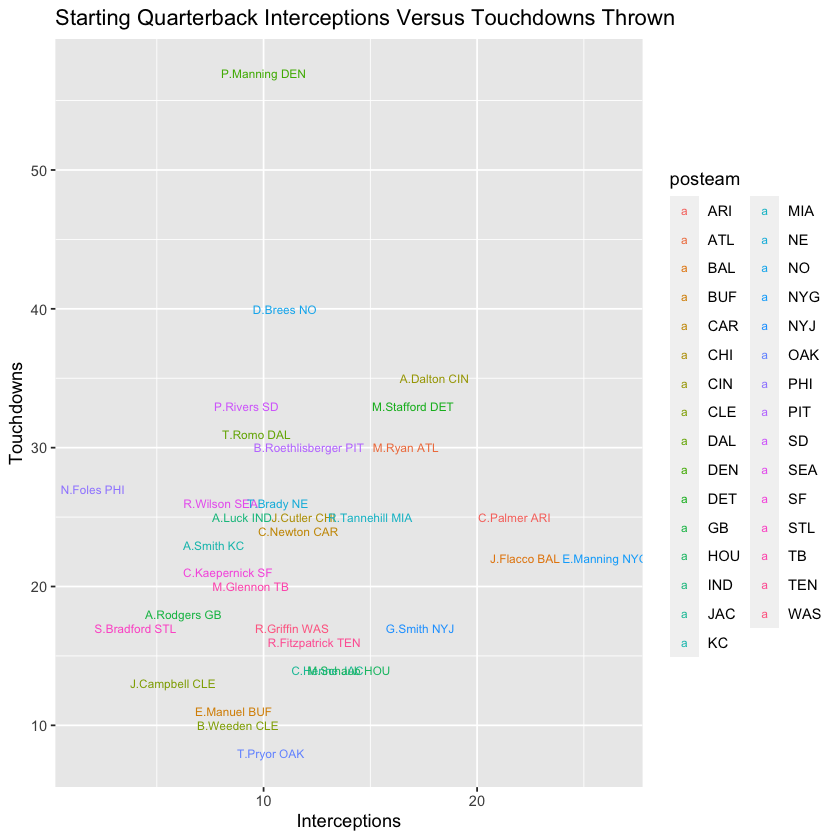

In [111]:
ggplot(data = quarterback_performance) +
geom_text(aes(x = Interceptions, y = Touchdowns, color = posteam, label= Quarterback),
         position = position_dodge(width= 1),  size = 2.5) +
labs(title = "Starting Quarterback Interceptions Versus Touchdowns Thrown")


This model helps us to visualize which quarterbacks had a better year in terms of interceptions and touchdowns with quarterbacks who had better season being on the upper left part of the graph(high touchdowns + low interceptions thrown = a good season for a quarterback) while quarterbacks who had a bad season being on the bottom right of the figure (low touchdowns + high interception thrown = a bad season for a quarterback)'

Warning message:
“Removed 4 rows containing missing values (geom_text).”


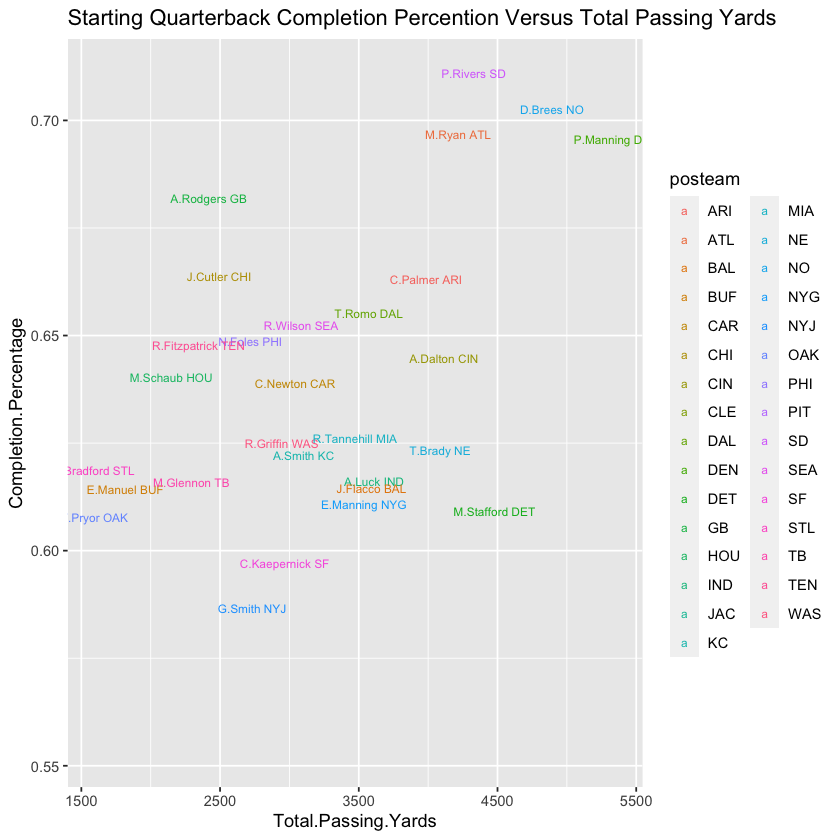

In [112]:
ggplot(data = quarterback_performance) +
geom_text(aes(x = Total.Passing.Yards, y = Completion.Percentage, color = posteam, label= Quarterback),
         position = position_dodge(width= 1),  size = 2.5) +
labs(title = "Starting Quarterback Completion Percention Versus Total Passing Yards")

This model helps us to visualize which starting quarterbacks had a better year in terms of completion percentage and total passing yards. Quarterbacks who performed well in the 2013 in terms of these will show up in the upper right corner of the figure because high completion percentage and high passing yards usually mean a quarterback had a good season. On the other hand though quarterbacks who had a bad season tend to be in the lower left hand corner because lower completion percentage and low passing yards usually mean a quarterback underperformed during that season'

Conclusion from Question: Based on the figures and statistics shown the quarterback who had the best season was P.Manning. This is because during the 2013 season he threw for the most amount of touchdowns and total passing yards, in both of these the person who threw for the second amount was much lower than him as well. He also had the fourth highest completion percentage and for interceptions thrown was in the middle of the pack. The quarterback who had the worst season was T.Pryor. Not only did T.Pryor graduate from Ohio State he also threw for the least amount of touchdowns, was second to last in passing yards and fifth worst completetion percentage. So in conclusion the starting quarterback who had the best 2013 season was P.Manning and the worst was T.Pryor.

# Question 4 - Owen
## What Was the Most Profitable Betting Category in the 2013 NFL Season?

Taking a look at the 2013 NFL data, we want to know which category: home favorite, away favorite, home underdog, away underdog, was the most profitable. We will investigate how these team do against their respective point spreads.  

In [98]:
games_spreads <- left_join(games, spreads, by = c("week" = "schedule_week", "home_team", "away_team")) %>% print

# A tibble: 256 x 28
   type  game_id home_abb away_abb  week season state_of_game game_url
   <chr>   <dbl> <chr>    <chr>    <dbl>  <dbl> <chr>         <chr>   
 1 reg    2.01e9 DEN      BAL          1   2013 POST          http://~
 2 reg    2.01e9 BUF      NE           1   2013 POST          http://~
 3 reg    2.01e9 PIT      TEN          1   2013 POST          http://~
 4 reg    2.01e9 NO       ATL          1   2013 POST          http://~
 5 reg    2.01e9 NYJ      TB           1   2013 POST          http://~
 6 reg    2.01e9 JAC      KC           1   2013 POST          http://~
 7 reg    2.01e9 CAR      SEA          1   2013 POST          http://~
 8 reg    2.01e9 CHI      CIN          1   2013 POST          http://~
 9 reg    2.01e9 CLE      MIA          1   2013 POST          http://~
10 reg    2.01e9 DET      MIN          1   2013 POST          http://~
# ... with 246 more rows, and 20 more variables: home_score <dbl>,
#   away_score <dbl>, id <chr>, home_team <chr>, away_team <

Since there is no key present in the spreads data set, we needed to join them based on home_team, away_team, and week.

In [28]:
games_favorites <- games_spreads %>% mutate(positive_spread = -1*spread_favorite, 
                   home_away_favorite = ifelse(home_abb == team_favorite_id, "Home Favorite", "Away Favorite"))

games_favorites %>% select(home_abb, away_abb, team_favorite_id, positive_spread, home_away_favorite) %>% print

# A tibble: 256 x 5
   home_abb away_abb team_favorite_id positive_spread home_away_favorite
   <chr>    <chr>    <chr>                      <dbl> <chr>             
 1 DEN      BAL      DEN                          7.5 Home Favorite     
 2 BUF      NE       NE                          10.5 Away Favorite     
 3 PIT      TEN      PIT                          6   Home Favorite     
 4 NO       ATL      NO                           3.5 Home Favorite     
 5 NYJ      TB       TB                           6   Away Favorite     
 6 JAC      KC       KC                           4.5 Away Favorite     
 7 CAR      SEA      SEA                          3.5 Away Favorite     
 8 CHI      CIN      CHI                          3   Home Favorite     
 9 CLE      MIA      CLE                          2.5 Home Favorite     
10 DET      MIN      DET                          4.5 Home Favorite     
# … with 246 more rows


We needed to multiply the spreads by -1 in order for them to be a positive number, and easier to work with. Also, we added a column that determined whether the favorite was home or away for the game.  

In [29]:
games_results <- games_favorites %>% 
mutate(result = 
ifelse((home_away_favorite == "Home Favorite" & (score_home - score_away) > positive_spread) | 
(home_away_favorite == "Away Favorite" & (score_away - score_home) > positive_spread), 
       "covered", ifelse((home_away_favorite == "Home Favorite" & (score_home - score_away) == positive_spread) | 
(home_away_favorite == "Away Favorite" & (score_away - score_home) == positive_spread),"push", "not covered")))

games_results %>% count(home_away_favorite, result)

home_away_favorite,result,n
Away Favorite,covered,40
Away Favorite,not covered,53
Away Favorite,push,5
Home Favorite,covered,80
Home Favorite,not covered,74
Home Favorite,push,4


This code allowed us to conclude whether or not the favorite covered the spread (won by more than positive_spread). "covered" means that the favorite covered the spread, and "not covered" means that the underdog covered the spread, and "push" means that the difference in the score was exactly predicted by the pregame point spread. 

`summarise()` regrouping output by 'home_away_favorite' (override with `.groups` argument)
Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

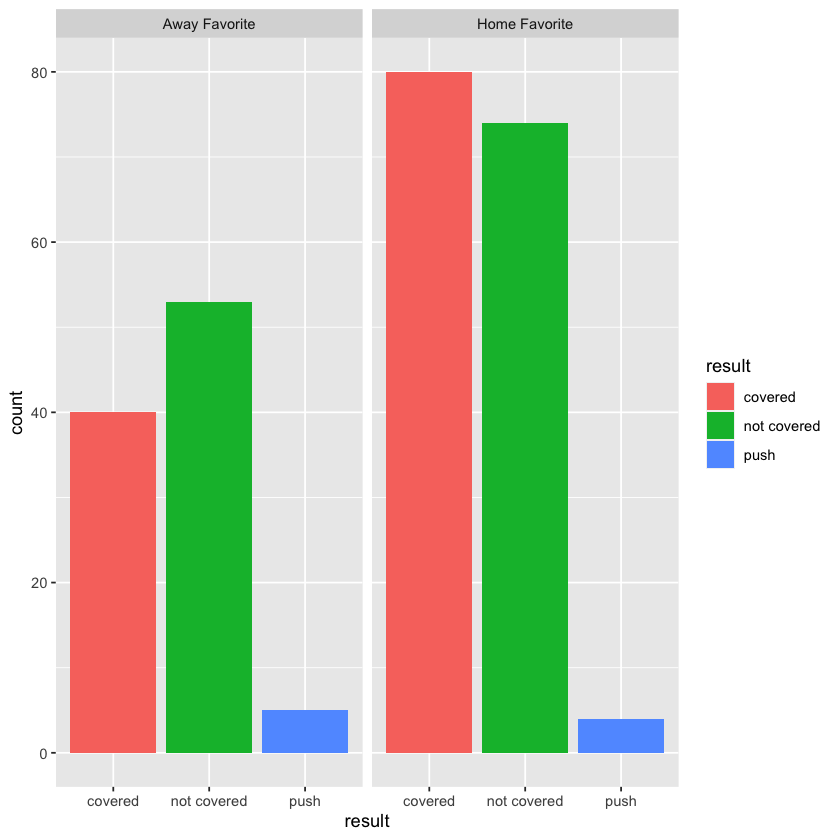

In [30]:
games_results %>% group_by(home_away_favorite, result) %>% summarize(count = n()) %>% 
ggplot() + geom_histogram(mapping = aes(x = result, y = count, fill = result),stat = "identity") + 
facet_wrap(~ home_away_favorite)

From this, we can see that home favorites covering the spread is the most frequent, however, it is not the most profitable betting category because the underdog covers the spread almost as often. According to the data, the home favorite covered the spread in 80 games in 2013, did not cover the spread in 74 games, and pushed in 4 games. This means that if you were to bet on every home favorite in the 2013 season, you would have won 6 times, and would have gotten your money back 4 times. The next interesting piece about this plot is that when the away team is the favorite, they actually cover the spread less often; meaning the home underdog covers the spread. According to the data, the away favorite covered the spread in 40 games, did not cover the spread in 53 games, and pushed in 5 games. This means that if you were to bet on the away favorite for every instance in 2013, you would have won 40 times, lost 53 times, and gotten your money back 5 times. 

In [31]:
bet_amount = 11 # bet amount set to 11 because each game has 10/11 odds. That is, bet $11 and profit $10

profits <- games_results %>% filter(result != "push") %>%
group_by(home_away_favorite, week) %>% 
summarize(total_games = n(), covered = sum(result == "covered"), not_covered = total_games - covered) %>%
mutate(profit_fav = (1.91*bet_amount)*covered - (bet_amount*total_games), # 1.91 is the decimal form of 10/11 odds.
       profit_underdog = (1.91*bet_amount)*not_covered - (bet_amount*total_games))
for(i in 2:17){
    # Away favorite's cumulative profit:
        profits$profit_fav[i] = profits$profit_fav[i] + profits$profit_fav[i-1]
    # Home favorite's cumulative profit:
        profits$profit_fav[i+17] = profits$profit_fav[i+17] + profits$profit_fav[(i-1)+17]
    # Home underdog's cumulative profit:
        profits$profit_underdog[i] = profits$profit_underdog[i] + profits$profit_underdog[i-1]
    # Away underdog's cumulative profit:
        profits$profit_underdog[i+17] = profits$profit_underdog[i+17] + profits$profit_underdog[(i-1)+17]
}

profits

`summarise()` regrouping output by 'home_away_favorite' (override with `.groups` argument)


home_away_favorite,week,total_games,covered,not_covered,profit_fav,profit_underdog
Away Favorite,1,6,2,4,-23.98,18.04
Away Favorite,2,4,1,3,-46.97,37.07
Away Favorite,3,5,2,3,-59.95,45.10
Away Favorite,4,8,4,4,-63.91,41.14
Away Favorite,5,8,2,6,-109.89,79.20
Away Favorite,6,5,3,2,-101.86,66.22
Away Favorite,7,6,3,3,-104.83,63.25
Away Favorite,8,5,3,2,-96.80,50.27
Away Favorite,9,7,3,4,-110.77,57.31
Away Favorite,10,6,4,2,-92.73,33.33


This code filters out the pushes, and counts the cumulative profits for each category. We filtered out the pushes because when a bet pushes, you do not gain or lose money. In the table above, the profit_fav or profit_underdog corresponding to week 17 is the total cumulative profit for that category. 

New names:
* home_away_favorite -> home_away_favorite...1
* week -> week...2
* total_games -> total_games...3
* covered -> covered...4
* not_covered -> not_covered...5
* ...


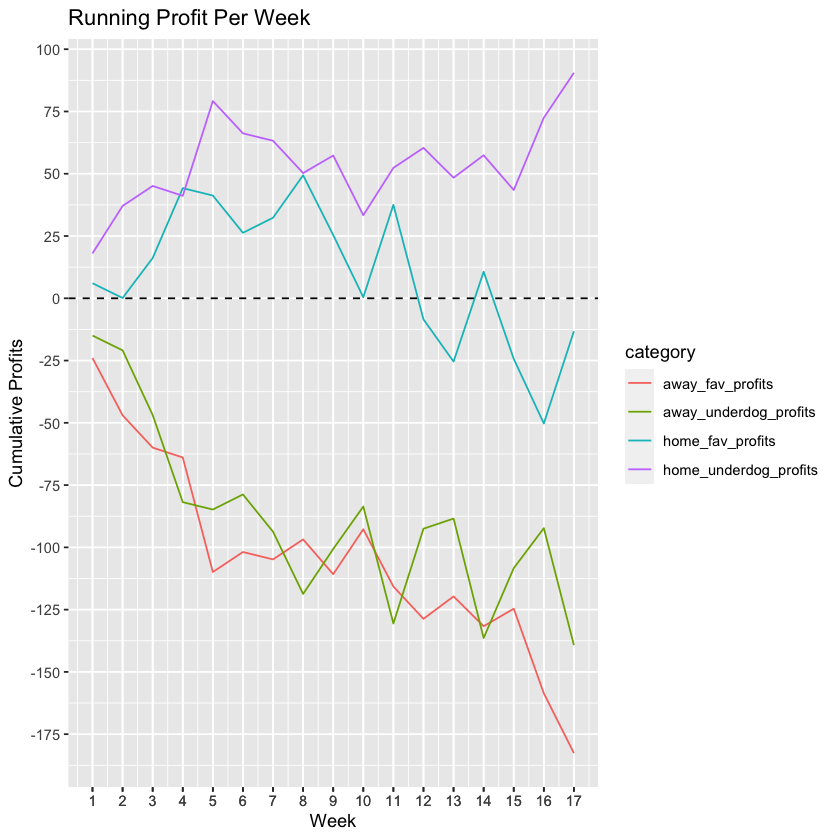

In [45]:
cbind(filter(profits, home_away_favorite == "Away Favorite"), 
      filter(profits, home_away_favorite == "Home Favorite")) %>%
select(week...2, profit_fav...6, profit_underdog...7, profit_fav...13, profit_underdog...14) %>% 
rename(away_fav_profits = profit_fav...6, home_underdog_profits = profit_underdog...7, 
      home_fav_profits = profit_fav...13, away_underdog_profits = profit_underdog...14, week = week...2) %>%
gather(key = category, value = profit, c(away_fav_profits, home_underdog_profits, home_fav_profits, 
                                                                            away_underdog_profits)) %>%

ggplot() + geom_line(mapping = aes(x = week, y = profit, color = category)) + 
scale_x_continuous(breaks = profits$week) +
scale_y_continuous(breaks = c(-200, -175, -150, -125, -100, -75, -50, -25, 0, 25, 50, 75, 100)) +
geom_hline(yintercept = 0, color = "black", linetype = "dashed") +
ggtitle("Running Profit Per Week") +
labs(x = "Week", y = "Cumulative Profits")

As you can see from the graph, the only profitable category to bet on in the long run is home underdogs. That is, if you were to bet \\$11 on every home underdog from the 2013 NFL season, at the end of the season, you would have $90.53 in profit. This is interesting because it shows that home-field advantage seems to exist when it comes to covering the spread as an underdog.

# Conclusion
After analyzing each of the four questions, we were able to draw some type of conclusion for each. For the question relating draft order and score against spread, we concluded that there is no strong correlation between the two variables from both a player's and team's perspective. For the next question relating weather and play selection, we concluded that lower temperatures and higher wins lead to a slightly higher run/pass ratio on average. When we tried to figure out the best and worst QBs for the season, we found that Peyton Manning was the best and Terrell Pryor was the worst (not surprising given his educational background). Finally, when we tried to figure what betting category was the most profitable, we determined that betting on the home underdogs for the entire season would be profitable. This is interesting because it seems there is a home-field advantage when it comes to covering the spread. These questions don't have many mutual connections, so they all lead to individual conclusions. It's interesting that we were able to find varying conclusions all from the same set of data.